### In this notebook, we run experiments for in-context ODEs. We compare the performance of the Transformer, BaseConv, GD, and least squares.

In [1]:
# Imports
import sys, os
sys.path.append("/scratch/precision-ls/")
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.models import get_model_from_run
from src.datagen.main import get_data_sampler, get_task_sampler

device = "cuda" if torch.cuda.is_available() else "cpu"

# Save dir
save_dir = "/scratch/precision-ls/notebooks"

### Load models

In [16]:
# Folder containing model checkpoints
run_dir = "/scratch/precision-ls/models/"

# Transformer ODE model checkpoints
run_ids = {
    4: "task=odesiclfinal/14c81a1c-960a-4b14-818f-092b3646175e",
    8: "task=odesiclfinal/576ade63-0753-4b28-aa1d-f4b485be83fe",
    12: "task=odesiclfinal/13eaab29-6a9b-4c62-8d2c-6ba5833c88b1",
    16: "task=odesiclfinal/95857faa-b95a-4406-98a7-218ed76f1184",
    24: "task=odesiclfinal/1fe0fc66-711a-4556-8110-df1f5a8931d9",
}

run_paths = {key: os.path.join(run_dir, run_ids[key]) for key in run_ids.keys()}

# BaseConv gradient descent model checkpoints
gd_run_ids = {
    "gd": "task=explicitgradient/bbfcc74c-91ea-4879-9eae-0d5c32c63e61",
}

gd_run_paths = {key: os.path.join(run_dir, gd_run_ids[key]) for key in gd_run_ids.keys()}

In [3]:
# Eval model
batch_size = 128

def get_model(key, run_paths=run_paths):
    model, conf = get_model_from_run(run_paths[key])
    model = model.to(device=device)
    print(model)
    
    if "data_kwargs" not in conf.training.keys():
        conf.training.data_kwargs = {}
    if "task_kwargs" not in conf.training.keys():
        conf.training.task_kwargs = {}
    
    n_dims = conf.model.n_dims
    
    conf.training.data_kwargs["eqn_class"] = 1
    
    data_sampler = get_data_sampler(conf.training.data, n_dims=n_dims, batch_size=batch_size, n_points=conf.training.curriculum.points.end, **conf.training.data_kwargs)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims=n_dims,
        batch_size=batch_size,
        n_points=conf.training.curriculum.points.end,
        **conf.training.task_kwargs
    )
    task = task_sampler()
    metric = task.get_training_metric()
    eval_metric = task.get_metric()
    
    return model, conf, data_sampler, task, metric, eval_metric

def eval_model(key):
    model, conf, data_sampler, task, metric, eval_metric = get_model(key)
    model = model.to(device=device)
    
    # Sample data
    data_sample = data_sampler.sample(
        batch_size=batch_size,
        n_points=conf.training.curriculum.points.end,
        n_dims_truncated=conf.training.curriculum.dims.end,
    )

    # Write task data
    task_data = task.evaluate(data_sample)
    xs, ys = task_data["in"].to(device=device), task_data["out"].to(device=device)

    # Predict using model
    with torch.no_grad():
        pred = model(xs)
    
    # Eval
    out = metric(pred, ys)
    eval_out = eval_metric(pred, ys)
    
    return out, eval_out

## Eval ODEs

In [4]:
mses = {}
mses_25 = {}
mses_50 = {}
mses_75 = {}

for save_key in run_paths:
    mse, eval_out = eval_model(save_key)
    mse_batch = torch.mean(eval_out, dim=list(range(1, len(eval_out.shape)))).detach().cpu().numpy()
    mse_25 = np.percentile(mse_batch, 25, axis=-1)
    mse_75 = np.percentile(mse_batch, 75, axis=-1)
    mse_50 = np.median(mse_batch, axis=-1)
    
    mses[save_key] = mse
    mses_25[save_key] = mse_25
    mses_50[save_key] = mse_50
    mses_75[save_key] = mse_75
    
nlayers = list(run_paths.keys())

number of parameters: 3.16M


/scratch/icl_odes_dev/src/models/__init__.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path)


TransformerModel(
  (_read_in): Linear(in_features=24, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (transformer): ModuleDict(
      (wpe): Embedding(25, 256)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-3): 4 x Block(
          (ln_1): LayerNorm()
          (seq_mixer): CausalSelfAttention(
            (c_attn): Linear(in_features=256, out_features=768, bias=True)
            (c_proj): Linear(in_features=256, out_features=256, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=256, out_features=1024, bias=True)
            (c_intermediates): ModuleList()
            (activ): ReLU()
            (c_proj): Linear(in_features=1024, out_features=256, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm(

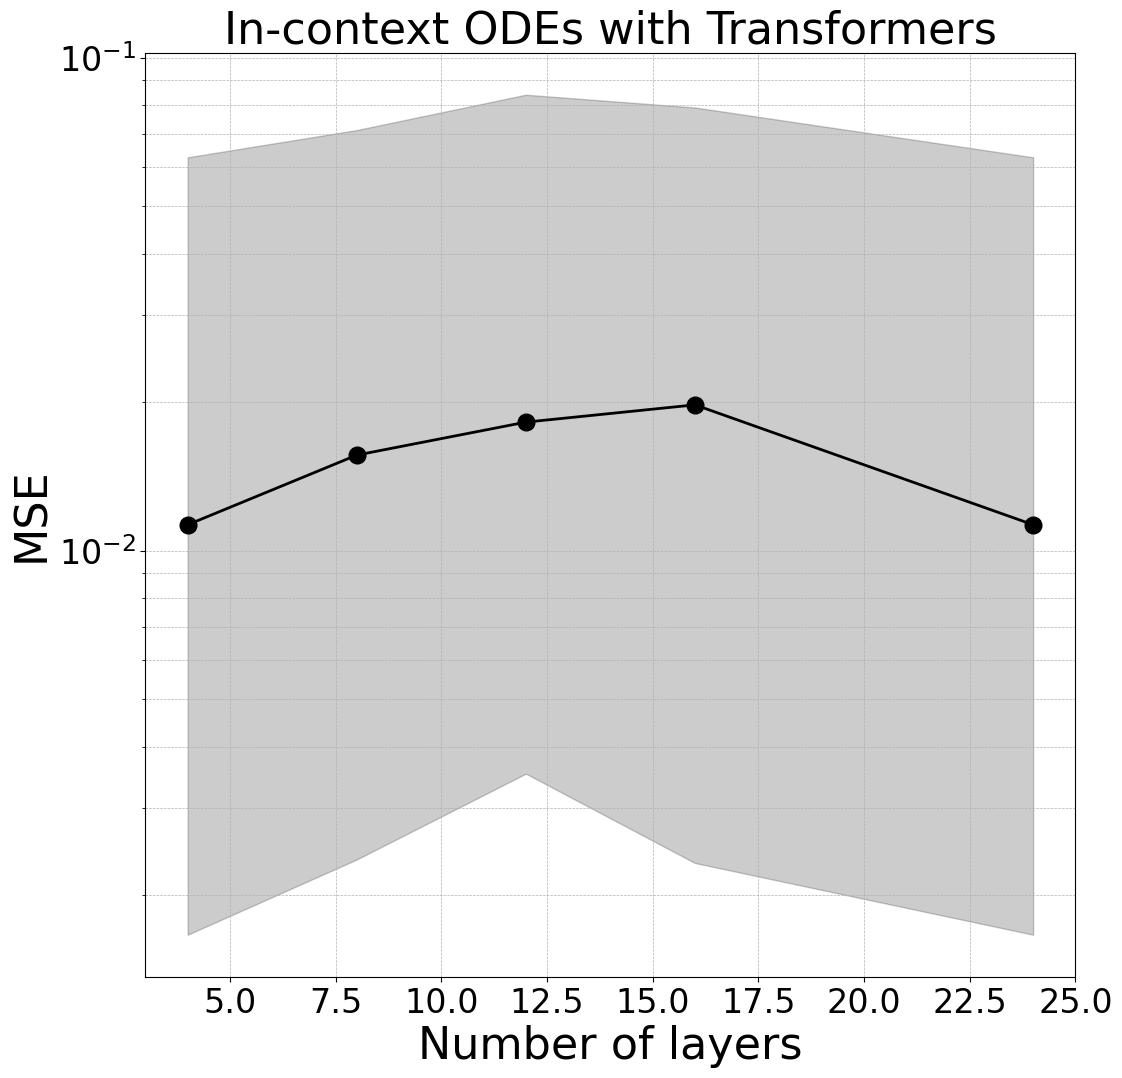

In [5]:
# Plot
plt.figure(figsize=(12,12))
plt.plot(nlayers, list(mses_50[nlayer] for nlayer in nlayers), marker="o", color="black", markersize=12, linewidth=2)
plt.fill_between(nlayers, list(mses_25[nlayer] for nlayer in nlayers), list(mses_75[nlayer] for nlayer in nlayers), color='black', alpha=0.2)
plt.title("In-context ODEs with Transformers", fontsize=32)
plt.xlabel("Number of layers", fontsize=32)
plt.ylabel("MSE", fontsize=32)
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(save_dir, "iclodes_attn_nlayers.png"))
plt.show()

### Code for evaluating out-of-distribution ODEs

In [7]:
def get_model_ood(key, ood_key=None, ood_factor=1):
    model, conf = get_model_from_run(run_paths[key])
    
    if "data_kwargs" not in conf.training.keys():
        conf.training.data_kwargs = {}
    if "task_kwargs" not in conf.training.keys():
        conf.training.task_kwargs = {}
    
    n_dims = conf.model.n_dims
    
    if ood_key:
        conf.training.data_kwargs[ood_key] *= ood_factor
    
    data_sampler = get_data_sampler(conf.training.data, n_dims=n_dims, batch_size=batch_size, n_points=conf.training.curriculum.points.end, **conf.training.data_kwargs)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims=n_dims,
        batch_size=batch_size,
        n_points=conf.training.curriculum.points.end,
        **conf.training.task_kwargs
    )
    task = task_sampler()
    metric = task.get_training_metric()
    eval_metric = task.get_metric()
    
    return model, conf, data_sampler, task, metric, eval_metric

In [8]:
def eval_ood(key, ood_key=None, ood_factor=1):
    model, conf, data_sampler, task, metric, eval_metric = get_model_ood(key, ood_key=ood_key, ood_factor=ood_factor)
    model = model.to(device=device)
    
    # Sample data
    data_sample = data_sampler.sample(
        batch_size=batch_size,
        n_points=conf.training.curriculum.points.end,
        n_dims_truncated=conf.training.curriculum.dims.end,
    )

    # Write task data
    task_data = task.evaluate(data_sample)
    xs, ys = task_data["in"].to(device=device), task_data["out"].to(device=device)

    # Predict using model
    with torch.no_grad():
        pred = model(xs)
    
    # Eval
    out = metric(pred, ys)
    eval_out = eval_metric(pred, ys)
    
    return out, eval_out

### Out-of-distribution: forcing functions

In [9]:
mses = {}
mses_25 = {}
mses_50 = {}
mses_75 = {}

save_key = 12
ood_factors = np.array([0.1, 0.2, 0.3, 0.5, 1, 3, 10])

for ood_factor in ood_factors:
    mse, eval_out = eval_ood(save_key, "gp_length", ood_factor)
    mse_batch = torch.mean(eval_out, dim=list(range(1, len(eval_out.shape)))).detach().cpu().numpy()
    mse_25 = np.percentile(mse_batch, 25, axis=-1)
    mse_75 = np.percentile(mse_batch, 75, axis=-1)
    mse_50 = np.median(mse_batch, axis=-1)
    
    mses[ood_factor] = mse
    mses_25[ood_factor] = mse_25
    mses_50[ood_factor] = mse_50
    mses_75[ood_factor] = mse_75

number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M


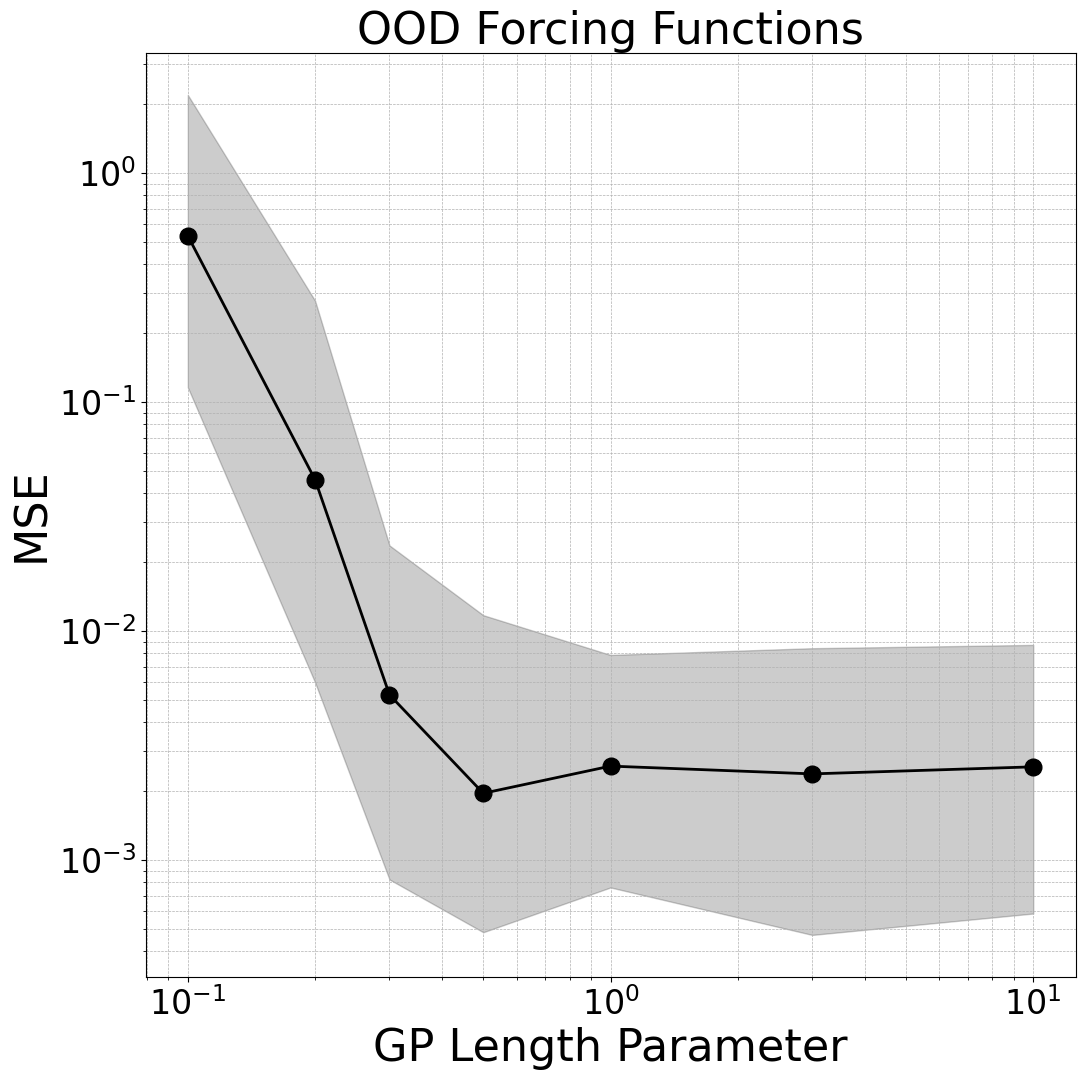

In [10]:
# Plot
plt.figure(figsize=(12,12))
plt.plot(ood_factors, list(mses_50[ood_factor] for ood_factor in ood_factors), marker="o", color="black", markersize=12, linewidth=2)
plt.fill_between(ood_factors, list(mses_25[ood_factor] for ood_factor in ood_factors), list(mses_75[ood_factor] for ood_factor in ood_factors), color='black', alpha=0.2)
plt.title("OOD Forcing Functions", fontsize=32)
plt.xlabel("GP Length Parameter", fontsize=32)
plt.xscale("log")
plt.ylabel("MSE", fontsize=32)
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(save_dir, "iclodes_attn_forcingfcn.png"))
plt.show()

### Out-of-distribution: ODE parameters

In [11]:
mses = {}
mses_25 = {}
mses_50 = {}
mses_75 = {}

save_key = 12
ood_factors = np.array([1/16, 1/4, 1, 4, 16])

for ood_factor in ood_factors:
    mse, eval_out = eval_ood(save_key, "operator_scale", ood_factor)
    mse_batch = torch.mean(eval_out, dim=list(range(1, len(eval_out.shape)))).detach().cpu().numpy()
    mse_25 = np.percentile(mse_batch, 25, axis=-1)
    mse_75 = np.percentile(mse_batch, 75, axis=-1)
    mse_50 = np.median(mse_batch, axis=-1)
    
    mses[ood_factor] = mse
    mses_25[ood_factor] = mse_25
    mses_50[ood_factor] = mse_50
    mses_75[ood_factor] = mse_75

number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
[ 0.0625  0.25    1.      4.     16.    ]
[np.float64(0.00026184209860059414), np.float64(0.00034411880126439666), np.float64(0.0007594492580980006), np.float64(0.0014310624486980027), np.float64(0.004961809978760292)]
[np.float64(0.0019262272538788597), np.float64(0.002199265702587332), np.float64(0.002572809013764653), np.float64(0.006343036843678736), np.float64(0.021011742413429662)]
[np.float64(0.0060414768161707235), np.float64(0.006115314492101203), np.float64(0.00786618296414054), np.float64(0.018662601394473628), np.float64(0.24959114299399554)]


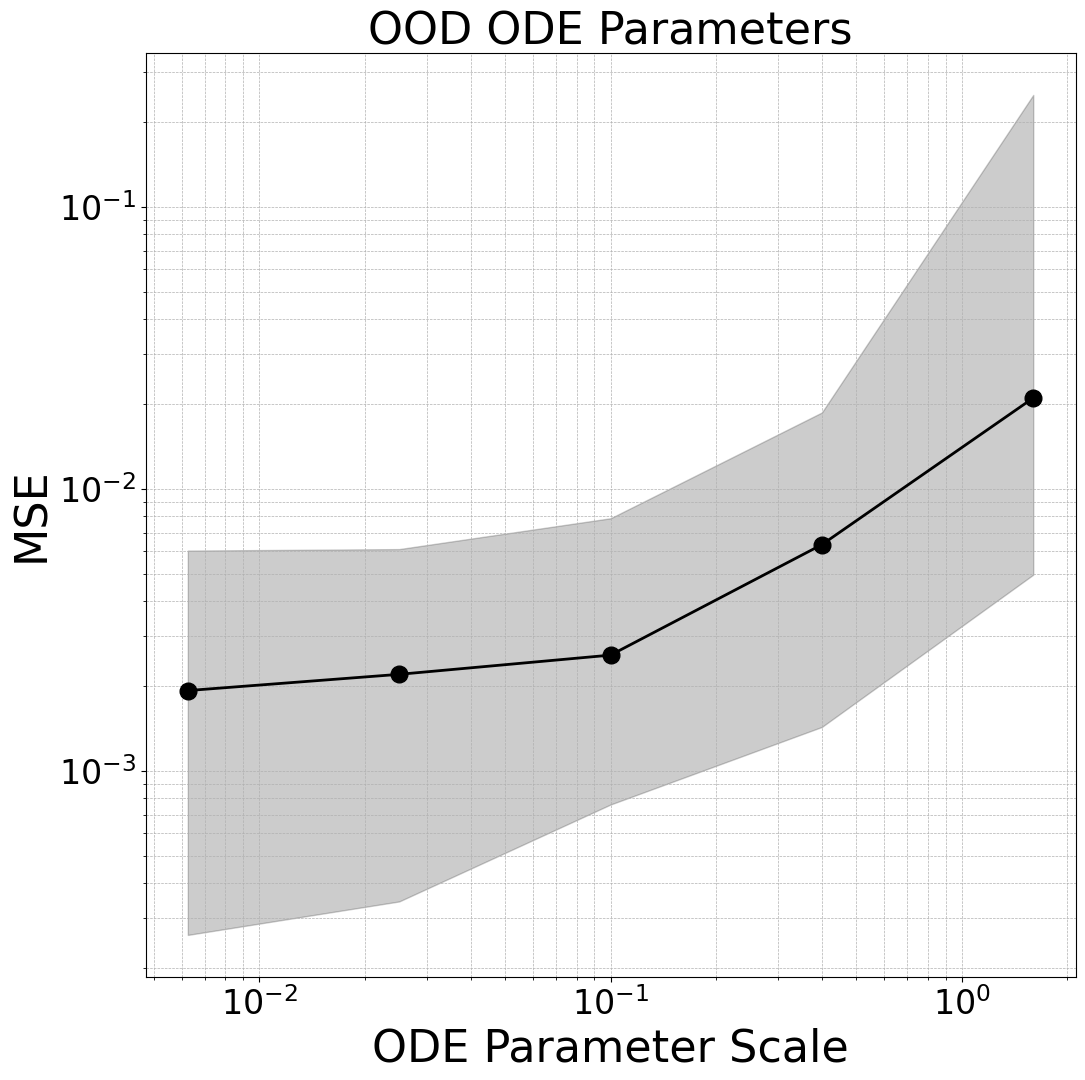

In [12]:
# Plot
plt.figure(figsize=(12,12))
plt.plot(0.1*ood_factors, list(mses_50[ood_factor] for ood_factor in ood_factors), marker="o", color="black", markersize=12, linewidth=2)
plt.fill_between(0.1*ood_factors, list(mses_25[ood_factor] for ood_factor in ood_factors), list(mses_75[ood_factor] for ood_factor in ood_factors), color='black', alpha=0.2)
plt.title("OOD ODE Parameters", fontsize=32)
plt.xlabel("ODE Parameter Scale", fontsize=32)
plt.xscale("log")
plt.ylabel("MSE", fontsize=32)
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(save_dir, "iclodes_attn_odeparams.png"))
plt.show()

### Out-of-distribution: u0 scale

In [13]:
mses = {}
mses_25 = {}
mses_50 = {}
mses_75 = {}

save_key = 12
ood_factors = np.array([1/16, 1/4, 1, 4, 16])

for ood_factor in ood_factors:
    mse, eval_out = eval_ood(save_key, "u0_scale", ood_factor)
    mse_batch = torch.mean(eval_out, dim=list(range(1, len(eval_out.shape)))).detach().cpu().numpy()
    mse_25 = np.percentile(mse_batch, 25, axis=-1)
    mse_75 = np.percentile(mse_batch, 75, axis=-1)
    mse_50 = np.median(mse_batch, axis=-1)
    
    mses[ood_factor] = mse
    mses_25[ood_factor] = mse_25
    mses_50[ood_factor] = mse_50
    mses_75[ood_factor] = mse_75

number of parameters: 9.48M


/scratch/icl_odes_dev/src/models/__init__.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path)


number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M
number of parameters: 9.48M


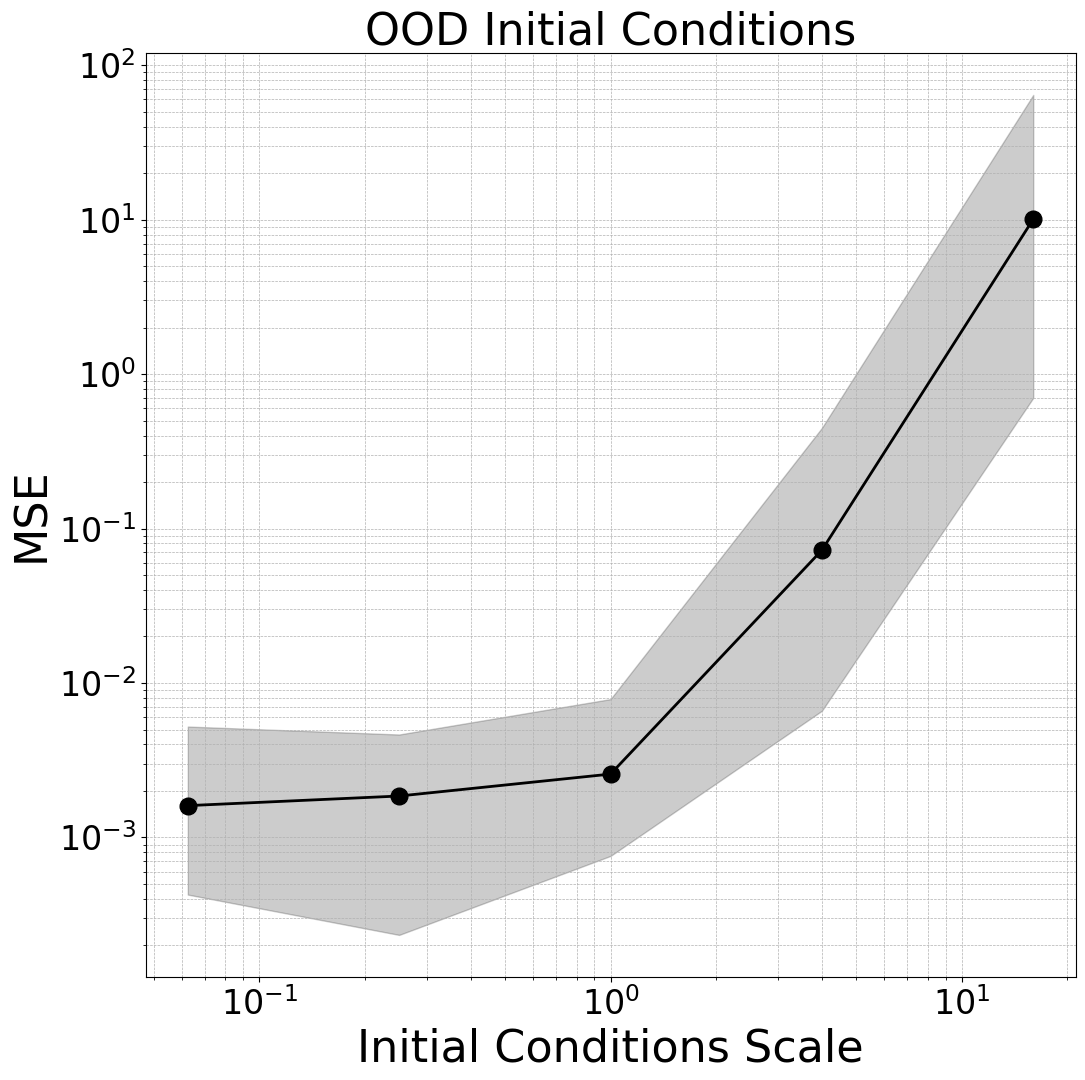

In [14]:
# Plot
plt.figure(figsize=(12,12))
plt.plot(ood_factors, list(mses_50[ood_factor] for ood_factor in ood_factors), marker="o", color="black", markersize=12, linewidth=2)
plt.fill_between(ood_factors, list(mses_25[ood_factor] for ood_factor in ood_factors), list(mses_75[ood_factor] for ood_factor in ood_factors), color='black', alpha=0.2)
plt.title("OOD Initial Conditions", fontsize=32)
plt.xlabel("Initial Conditions Scale", fontsize=32)
plt.xscale("log")
plt.ylabel("MSE", fontsize=32)
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(os.path.join(save_dir, "iclodes_attn_initial.png"))
plt.show()

### Gradient descent and least squares

In [17]:
from src.datagen.main.odes import ODEOperatorSampler

# Load gradient descent model
gd_model, gd_conf, gd_data_sampler, gd_task, gd_metric, gd_eval_metric = get_model("gd", run_paths=gd_run_paths)

# Load ODE task
_, _, _, ode_task, _, _ = get_model_ood(12, ood_key="gp_length", ood_factor=1)

# Set batch size, number of points, and number of dimensions (hardcoded from default ODE config)
batch_size = 5
L = 26
D = 20

Conv type = short
Conv type = short
Conv type = short
Conv type = short
number of parameters: 0.82M
TransformerModel(
  (_read_in): Linear(in_features=23, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (transformer): ModuleDict(
      (wpe): Embedding(26, 256)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-3): 4 x Block(
          (ln_1): Identity()
          (seq_mixer): BaseConvLayer(
            (base_conv): BaseConv(
              (projection): Linear(in_features=256, out_features=256, bias=True)
              (in_proj): Linear(in_features=256, out_features=256, bias=True)
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
              (conv): ShortConvolution(
                (conv): Conv1d(256, 256, kernel_size=(26,), stride=(1,), padding=(25,), groups=256)
              )
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
  )
  (_read_out): Linear(in_featur

/scratch/icl_odes_dev/src/models/__init__.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path)


number of parameters: 9.48M


In [21]:
# Compute grad (requires setting L)
def get_ls_grad(A, b, x_init, L=L):
    grad_true = torch.einsum(
        "bld,bl->bd",
        A,
        torch.einsum("bld,bd->bl", A, x_init) - b
    ).to(device=device) / (L-1)
    return grad_true

def get_ls_grad_pred(model, A, b, x_init):
    # Prompting
    gd_xs = torch.zeros((A.shape[0], L, D+3), device=device)
    gd_xs[:, 0, :-1] = x_init
    gd_xs[:, 1:, :-1] = A
    gd_xs[:, 1:, -1] = b

    # Predict gradient
    with torch.no_grad():
        grad_pred = model(gd_xs)[:, -1, :D+2].to(device=device)
        
    return grad_pred

In [22]:
def gradient_descent(A, b, A_q, b_q, num_iters=10000, lr=0.01, noise_std=0, model=None, setting="pred", num_increasing=500):
    
    min_losses = []
    
    for i in range(batch_size):
        
        x_init = torch.zeros(1, D+2).to(device=device)
        loss = float("inf")
        min_loss = float("inf")
        increasing_counter = 0

        for iter_i in range(num_iters):
            
            if setting == "pred":
                assert model is not None
                grad_true = get_ls_grad_pred(model, A[i:i+1], b[i:i+1], x_init)
            else:
                grad_true = get_ls_grad(A[i:i+1], b[i:i+1], x_init)

            grad_true += noise_std * torch.randn_like(grad_true)
            x_init -= lr * grad_true

            loss = (torch.einsum('bd,bd->b', x_init, A_q[i:i+1]) - b_q[i:i+1]).square()
            if loss.mean().item() < min_loss:
                min_loss = loss.mean().item()
            else:
                increasing_counter += 1
            if increasing_counter >= num_increasing:
                break

            if iter_i % 100 == 0:
                print(f"Iter {iter_i}: loss {loss.mean().item()}")
                
        min_losses.append(min_loss)

    min_losses = np.array(min_losses)
    mse_25 = np.percentile(min_losses, 25, axis=-1)
    mse_75 = np.percentile(min_losses, 75, axis=-1)
    mse_50 = np.median(min_losses, axis=-1)

    return [mse_25, mse_50, mse_75]
        

In [23]:
def least_squares_solvers(ode_task_data, gd_num_iters=100000, gd_lr=0.03):
    ode_xs, ode_ys = ode_task_data["in"], ode_task_data["out"]
    
    # Convert into least squares
    A = ode_xs[:, :-1, :-1].to(device=device) # (B, L, D)
    b = ode_xs[:, :-1, -1].to(device=device) # (B, L)
    A_q = ode_xs[:, -1, :-1].to(device=device) # (B, D)
    b_q = ode_ys.flatten().to(device=device) # (B)
    
    # Least squares
    x_ls_pred, _, _, _ = torch.linalg.lstsq(
        A.cpu(), b.cpu(), driver="gelsd",
    )
    x_ls_pred = x_ls_pred.to(device=device).reshape((batch_size, -1))
    mse_ls = (torch.einsum("bd,bd->b", x_ls_pred, A_q) - b_q).square().detach().cpu().numpy() # (B)
    mse_ls_25 = np.percentile(mse_ls, 25, axis=-1)
    mse_ls_75 = np.percentile(mse_ls, 75, axis=-1)
    mse_ls_50 = np.median(mse_ls, axis=-1)

    # Gradient descent
    mses_gdpred = gradient_descent(A, b, A_q, b_q, num_iters=gd_num_iters, lr=gd_lr, model=gd_model, setting="pred")
    mses_gdtrue = gradient_descent(A, b, A_q, b_q, num_iters=gd_num_iters, lr=gd_lr, model=None, setting="true")
    
    out_dict = {
        "ls": [mse_ls_25, mse_ls_50, mse_ls_75],
        "gdpred": mses_gdpred,
        "gdtrue": mses_gdtrue,
    }
    return out_dict

In [24]:
def eval_ood_least_squares(ood_key=None, ood_factor=1, gd_lr=0.05):
    # Define sampler
    ode_data_sampler = ODEOperatorSampler(
        n_dims=D,
        c_sampling="equispaced", # equispaced, cheb, randt
        eqn_class=1,
        operator_scale=0.1*ood_factor if ood_key=="operator_scale" else 0.1,
        gp_length=ood_factor if ood_key=="gp_length" else 1,
        u0_scale=ood_factor if ood_key=="u0_scale" else 1,
        seed=0,
        device="cuda",
    )

    # Sample
    ode_data = ode_data_sampler.sample(
        batch_size=batch_size,
        n_points=L,
        n_dims_truncated=D,
    )
    
    # Write task data
    ode_task_data = ode_task.evaluate(ode_data)
    
    # Eval
    out_dict = least_squares_solvers(ode_task_data, gd_lr=0.01)

    # Transformer
    mse, eval_out = eval_ood(save_key, ood_key, ood_factor)
    mse_batch = torch.mean(eval_out, dim=list(range(1, len(eval_out.shape)))).detach().cpu().numpy()
    mse_25 = np.percentile(mse_batch, 25, axis=-1)
    mse_75 = np.percentile(mse_batch, 75, axis=-1)
    mse_50 = np.median(mse_batch, axis=-1)
    out_dict["attn"] = [mse_25, mse_50, mse_75]

    return out_dict

In [25]:
# Run gradient descent and least squares
ode_dict = eval_ood_least_squares(ood_key=None, ood_factor=1, gd_lr=0.05)

Iter 0: loss 0.03982871662140842
Iter 100: loss 0.027086644529559552
Iter 200: loss 0.012810634938739152
Iter 300: loss 0.005604446104876294
Iter 400: loss 0.0023603763565563803
Iter 500: loss 0.0009611066577989128
Iter 600: loss 0.0003726632382597914
Iter 700: loss 0.0001320510505006509
Iter 800: loss 3.87466455073434e-05
Iter 900: loss 6.9342261771755595e-06
Iter 1000: loss 2.4123740233467077e-08
Iter 1100: loss 2.471916705535713e-06
Iter 1200: loss 7.760009112645773e-06
Iter 1300: loss 1.3254320158748622e-05
Iter 1400: loss 1.7989883120801558e-05
Iter 0: loss 0.05024737697699164
Iter 100: loss 0.30263341614547906
Iter 200: loss 0.13810866456819546
Iter 300: loss 0.06932632401228667
Iter 400: loss 0.036976454451001416
Iter 500: loss 0.020460307237694306
Iter 600: loss 0.011575775909015883
Iter 700: loss 0.006642041959238544
Iter 800: loss 0.003848971473577172
Iter 900: loss 0.0022485587920975728
Iter 1000: loss 0.001323877166688186
Iter 1100: loss 0.0007860805070442223
Iter 1200: los

/scratch/icl_odes_dev/src/models/__init__.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path)


### Plot: in-distribution Transformer, BaseConv, GD, and least squares

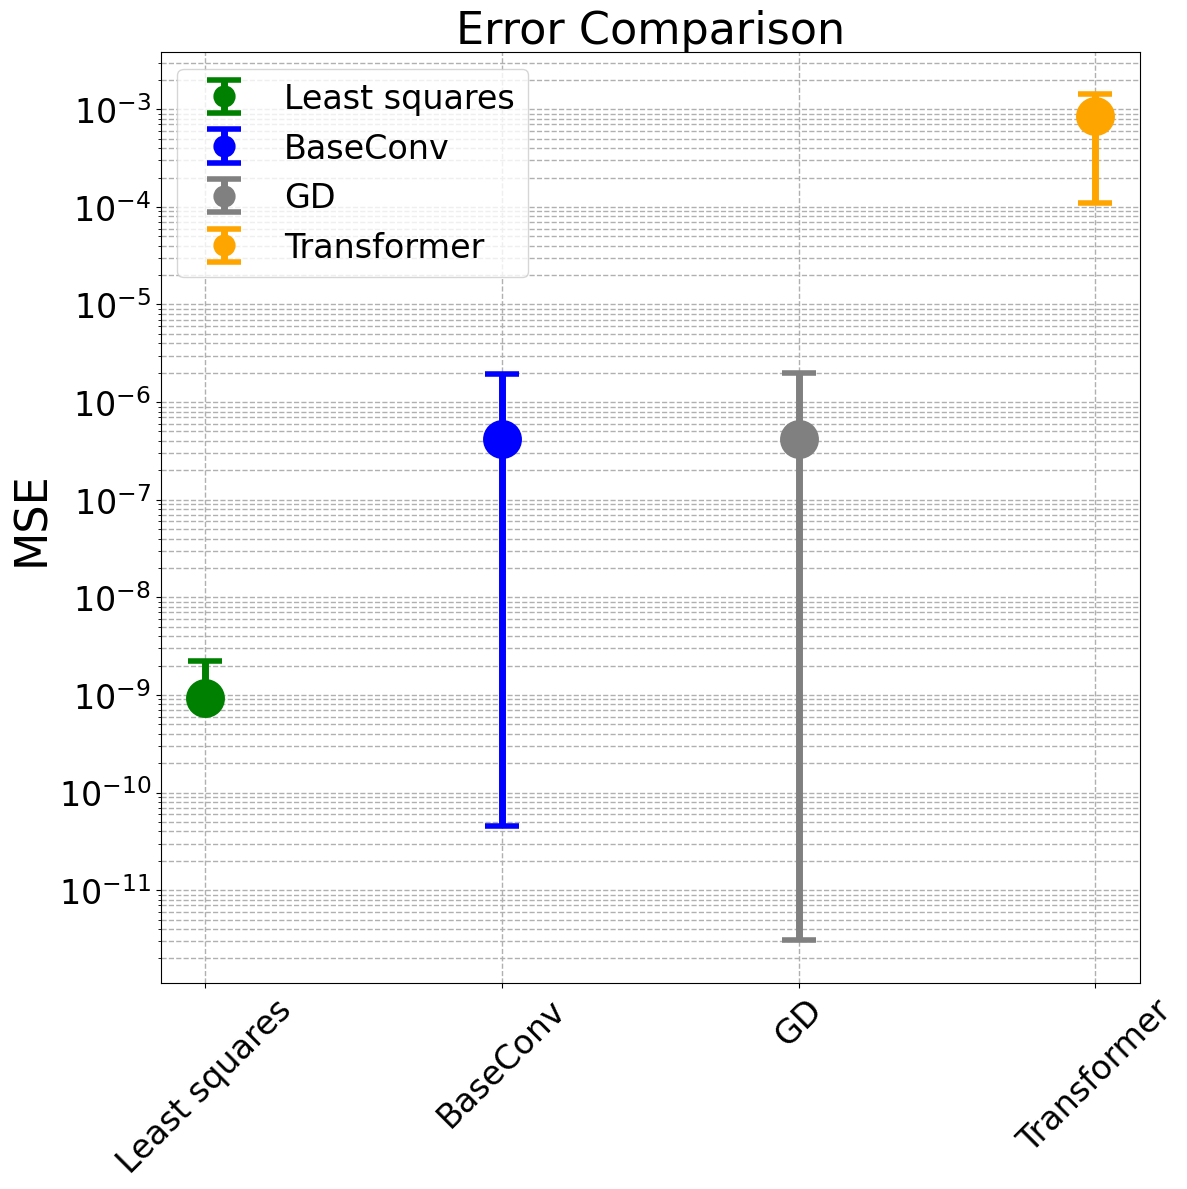

In [ ]:
key_dict = {
    "attn": "Transformer",
    "ls": "Least squares",
    "gdpred": "BaseConv", 
    "gdtrue": "GD",
}

color_dict = {
    "attn": "orange",
    "ls": "green",
    "gdpred": "blue",
    "gdtrue": "grey",
}

plt.figure(figsize=(12,12))

# Plot each method
x = np.arange(len(ode_dict))
for i, (method, values) in enumerate(ode_dict.items()):
    median = values[1]
    lower = values[0]
    upper = values[2]
    
    plt.errorbar(i, median, yerr=[[median-lower], [upper-median]],
                fmt='o', capsize=12, capthick=5,
                markersize=24,
                color=color_dict[method], 
                label=key_dict[method],
                linewidth=5,
                markeredgewidth=4)

plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=1.0)
plt.xticks(x, [key_dict[k] for k in ode_dict.keys()], rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('MSE', fontsize=32)
plt.title('Error Comparison', fontsize=32)
plt.legend(fontsize=24, markerscale=0.5)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "iclodes_all_indistribution.png"))
plt.show()